In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from isochrones import get_ichrone, SingleStarModel, BinaryStarModel

Holoviews not imported. Some visualizations will not be available.


In [2]:
from astroquery.mast import Observations, Catalogs

res = Catalogs.query_criteria(catalog="Tic", ID=165991532).to_pandas()

/Users/daniel/anaconda3/envs/isochrones/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'KIC' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/daniel/anaconda3/envs/isochrones/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'numcont' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
res

,ID,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,...,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID
0,165991532,20190415,68756,4174-01262-1,772-036991,14042335+6422331,NaN,J140423.31+642233.6,1667976701458550400,NaN,...,NaN,12.111298,9.383518,211.096762,64.375923,0.320942,0.278278,0,0,150439321


In [43]:
def create_param_list(row):
    params = {}
    
    # Plug in magnitudes
    band_key = [
#         'Gaia_BP_DR2Rev', 'Gaia_RP_DR2Rev', 
#                 'V', 'J', 'H', 'K',
#         'Tycho_V'
               'WISE_W1', 'WISE_W2', 'WISE_W3', 'WISE_W4', 
               ]
    bands = [
#         'gaiabp','gaiarp',
#              'Vmag', 'Jmag','Hmag','Kmag',
#         'Tycho VTmag'
            'w1mag','w2mag','w3mag','w4mag',
    ]
    avail_passbands = []
    for band, key in zip(bands, band_key):
        if not np.isnan(row[band]) and not np.isnan(row[f"e_{band}"]):
            params.update({
                 key: (row[band], row[f"e_{band}"])
#                 key: (row[band], row[f"e_Vmag_x"])
            })
            avail_passbands.append(key)
            
    # Time for some fundamental parameters. yeah baby!
    fund = ['Teff', 'logg', 'plx']
    keys = ['Teff', 'logg', 'parallax']
    
    for f, key in zip(fund, keys):
        if not np.isnan(row[f]) and not np.isnan(row[f"e_{f}"]):
            params.update({
                key: (row[f], row[f"e_{f}"])
            })
            
    return params, avail_passbands

In [44]:
def fit_isochrone(row):
    params, pb = create_param_list(row)
    mist = get_ichrone('mist', bands=pb)
    
    mod = SingleStarModel(mist, **params)
    mod.fit()
    
    mod_binary = BinaryStarModel(mist, **params)
    mod_binary.fit()
    
    return mod, mod_binary# Greater than 1 it favours the single model.. etc

In [45]:
mod, mod_binary = fit_isochrone(res.iloc[0])

/Users/daniel/anaconda3/envs/isochrones/lib/python3.6/site-packages/tables/attributeset.py:464: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_name[Fe/H]'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


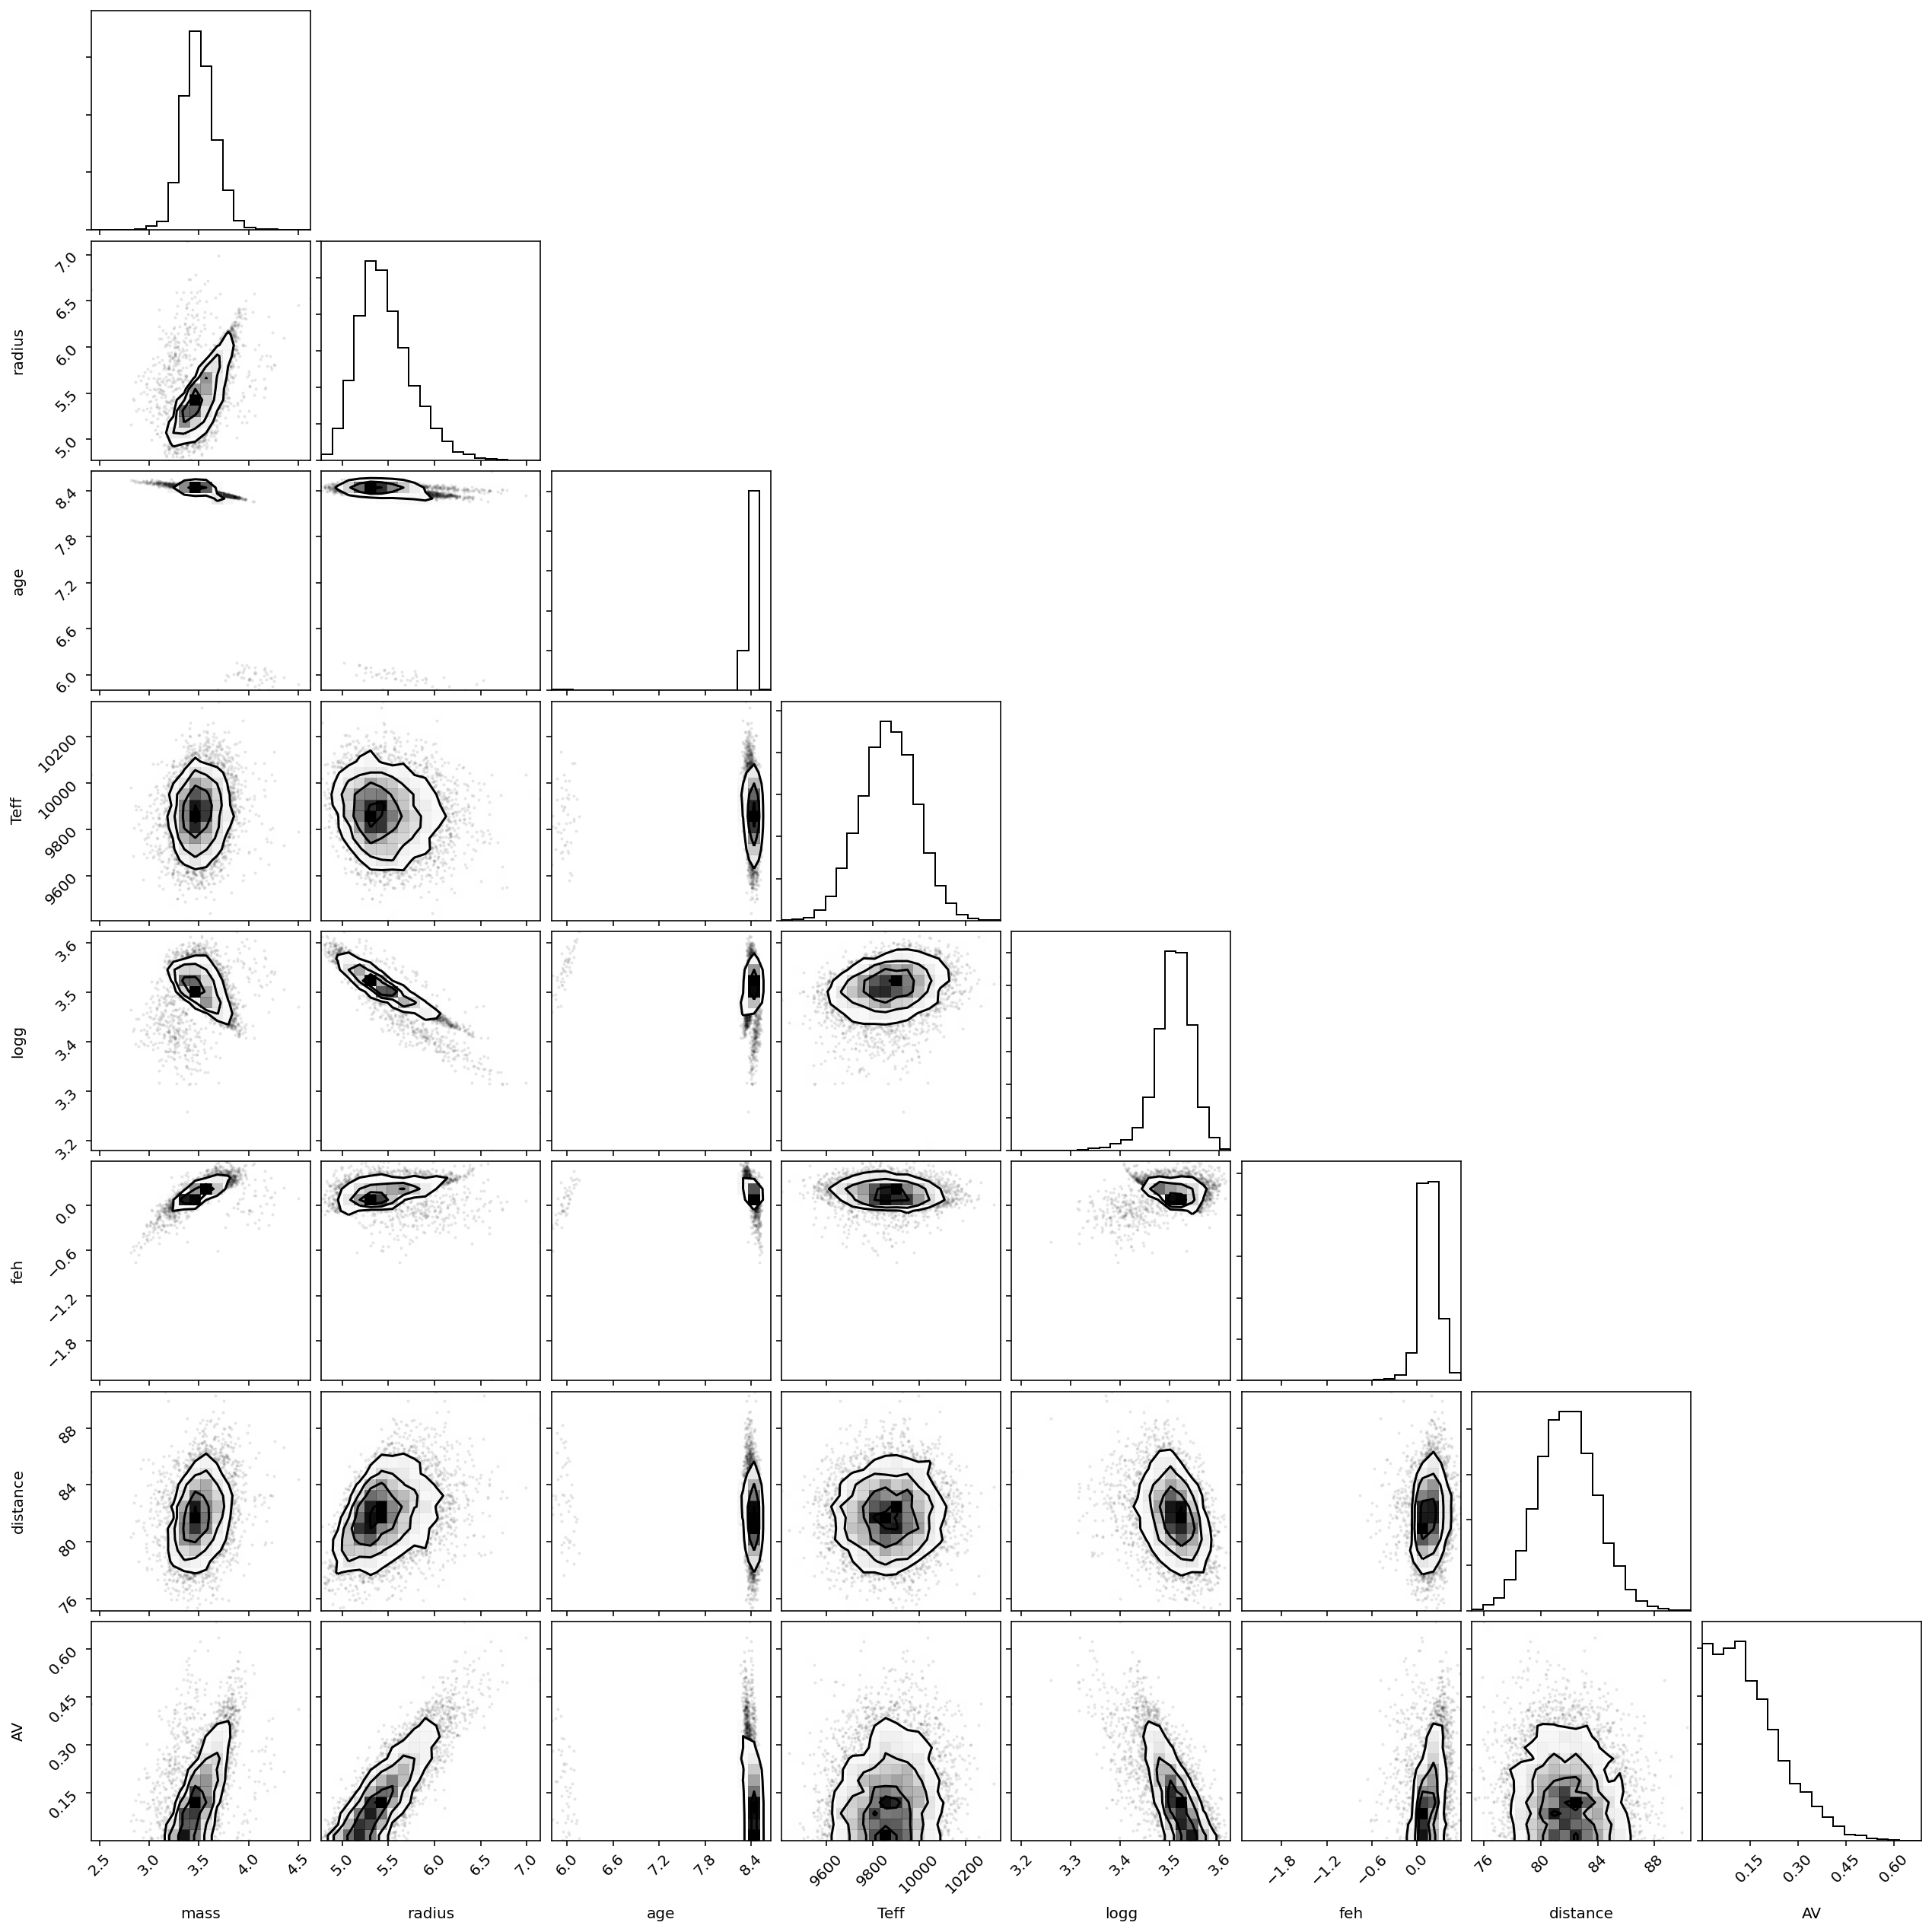

In [32]:
mod.corner_physical();

In [35]:
10**(np.median(mod.derived_samples.logL))

250.3282796376671

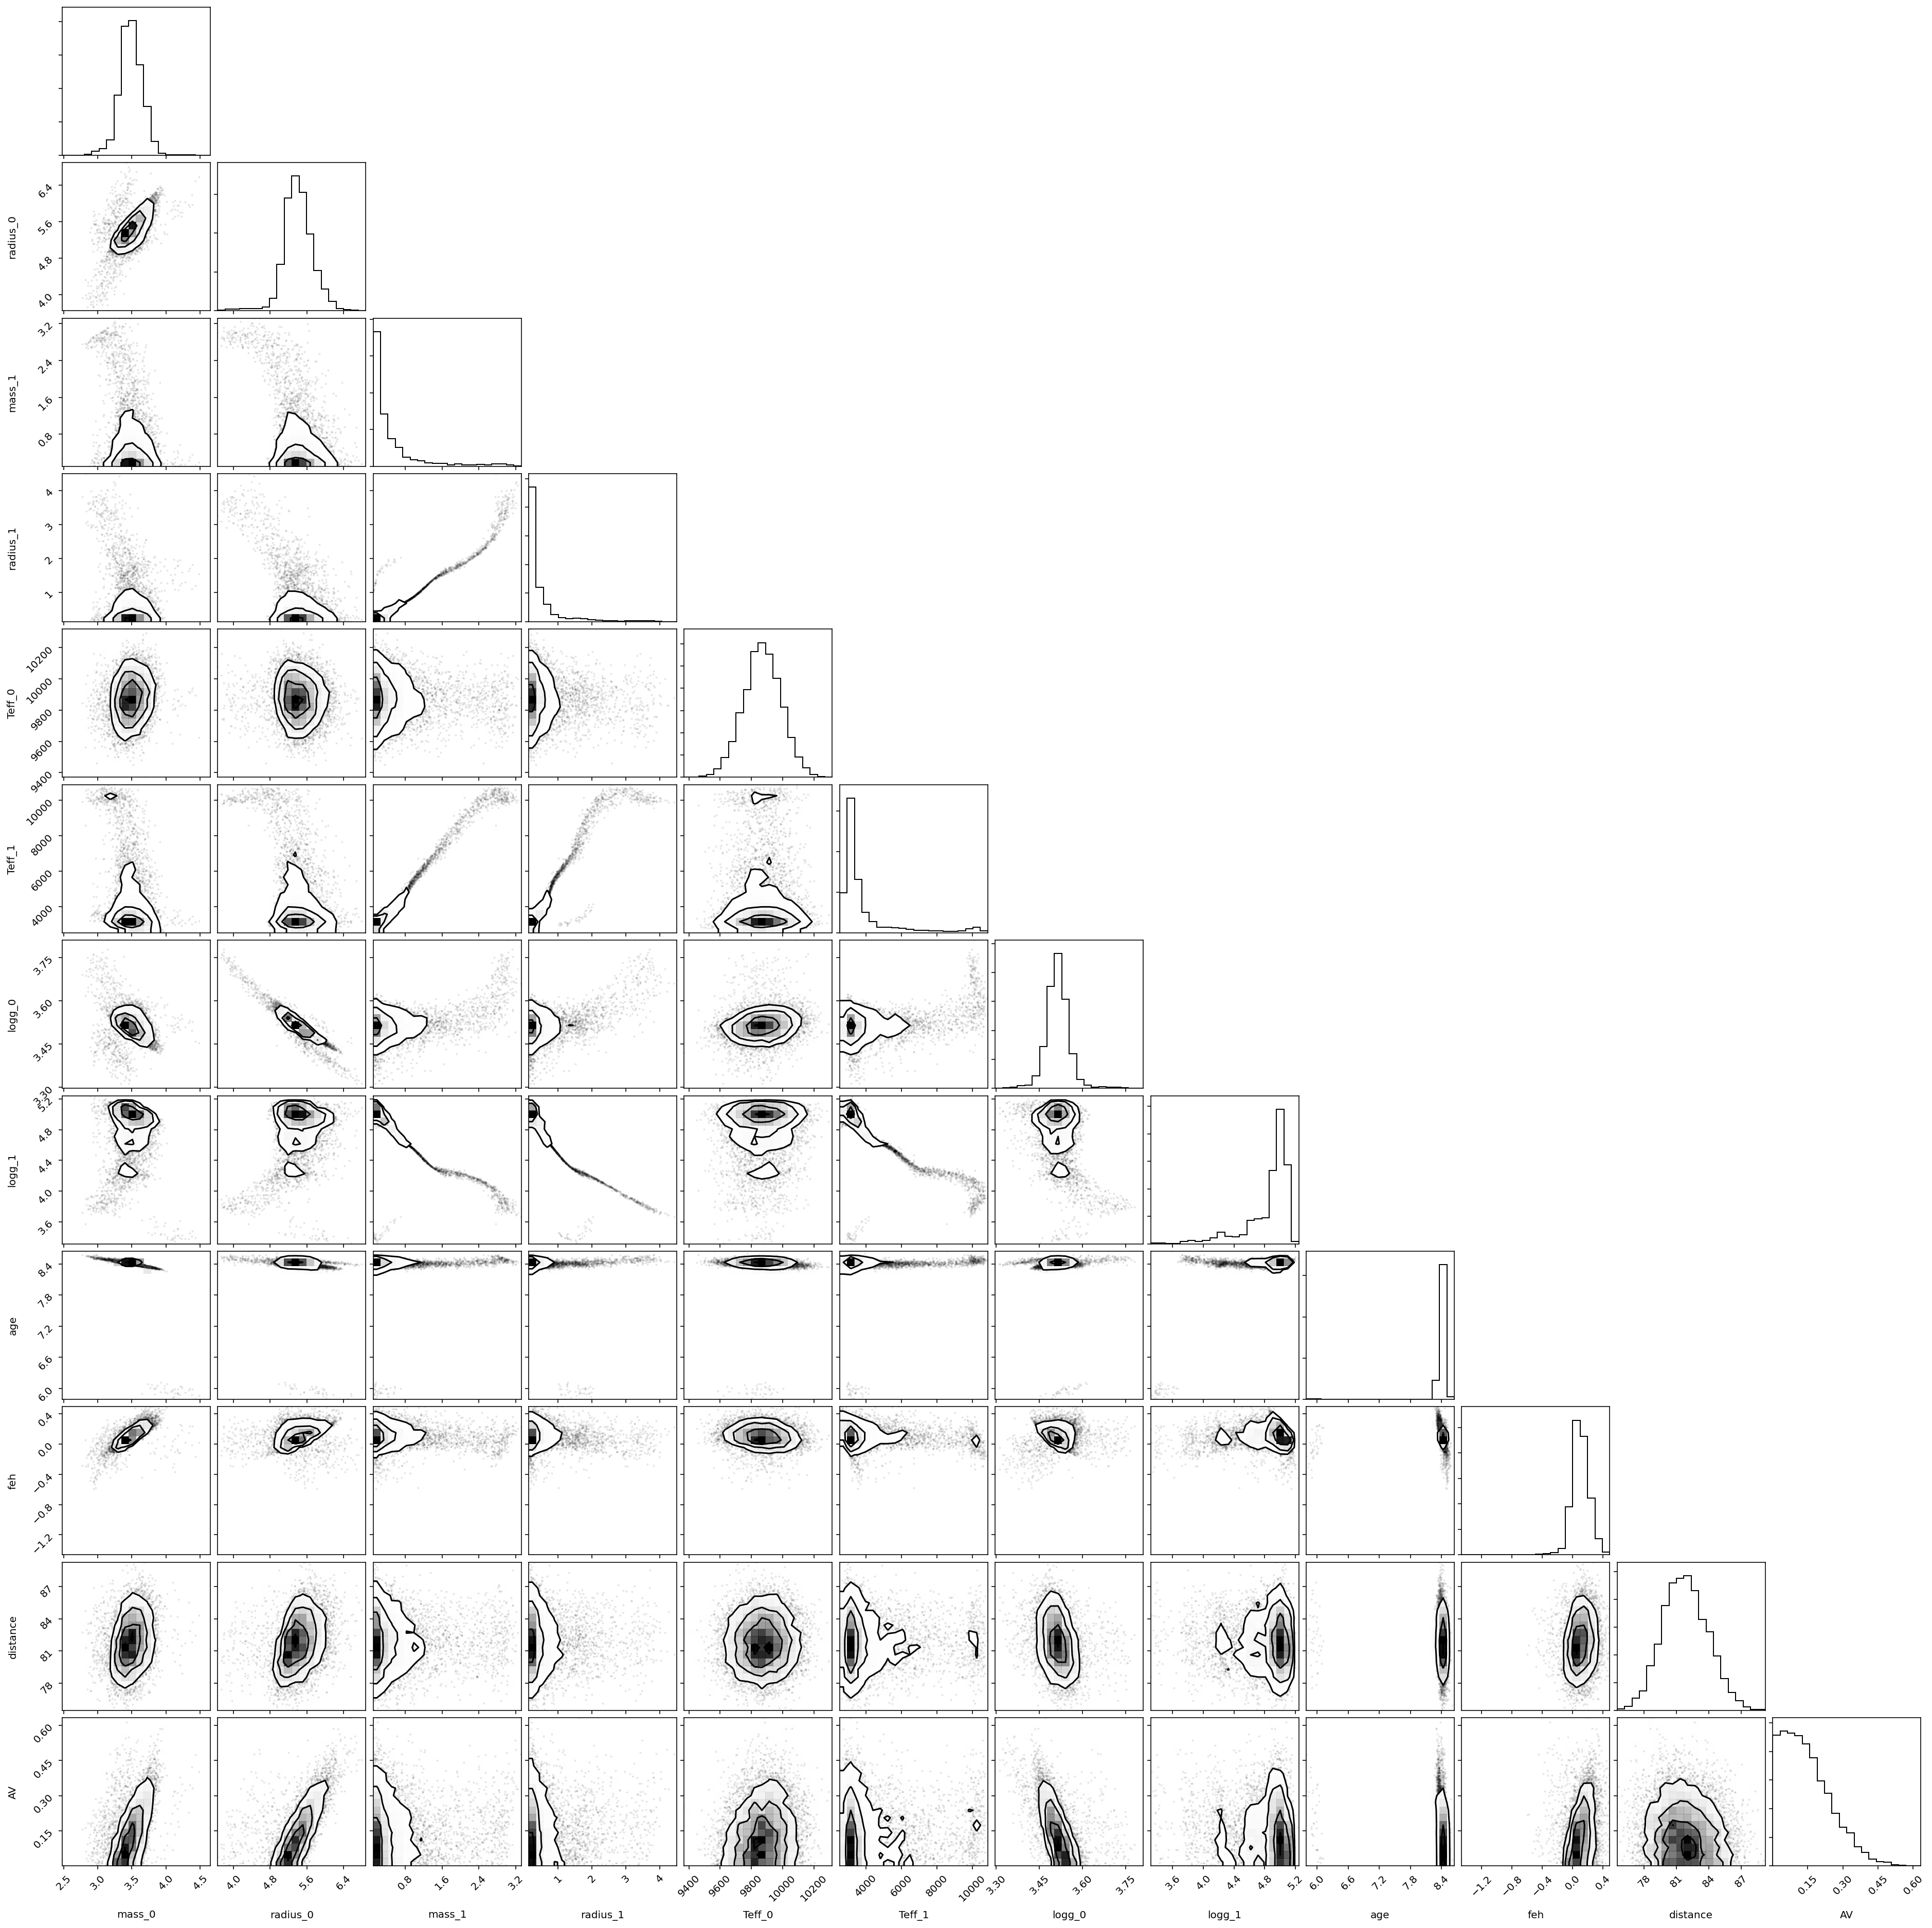

In [34]:
mod_binary.corner_physical();

In [36]:
Vmag_mc = mod.derived_samples.V_mag - 5 * (np.log10(mod.derived_samples.distance) - 1) + mod.derived_samples.AV
np.median(Vmag_mc), np.std(Vmag_mc)

(-0.7766272793972586, 0.1300321844334685)

In [37]:
np.log10(40)

1.6020599913279623

In [38]:
mod_binary.derived_samples.columns

Index(['eep_0', 'eep_1', 'age', 'feh', 'distance', 'AV', 'lnprob', 'feh_0',
       'mass_0', 'initial_mass_0', 'radius_0', 'density_0', 'logTeff_0',
       'Teff_0', 'logg_0', 'logL_0', 'Mbol_0', 'delta_nu_0', 'nu_max_0',
       'phase_0', 'dm_deep_0', 'V_mag_0', 'J_mag_0', 'H_mag_0', 'K_mag_0',
       'feh_1', 'mass_1', 'initial_mass_1', 'radius_1', 'density_1',
       'logTeff_1', 'Teff_1', 'logg_1', 'logL_1', 'Mbol_1', 'delta_nu_1',
       'nu_max_1', 'phase_1', 'dm_deep_1', 'V_mag_1', 'J_mag_1', 'H_mag_1',
       'K_mag_1', 'V_mag', 'J_mag', 'H_mag', 'K_mag', 'parallax'],
      dtype='object')

In [39]:
np.median(mod_binary.derived_samples.logL_1)

-2.093377483405772

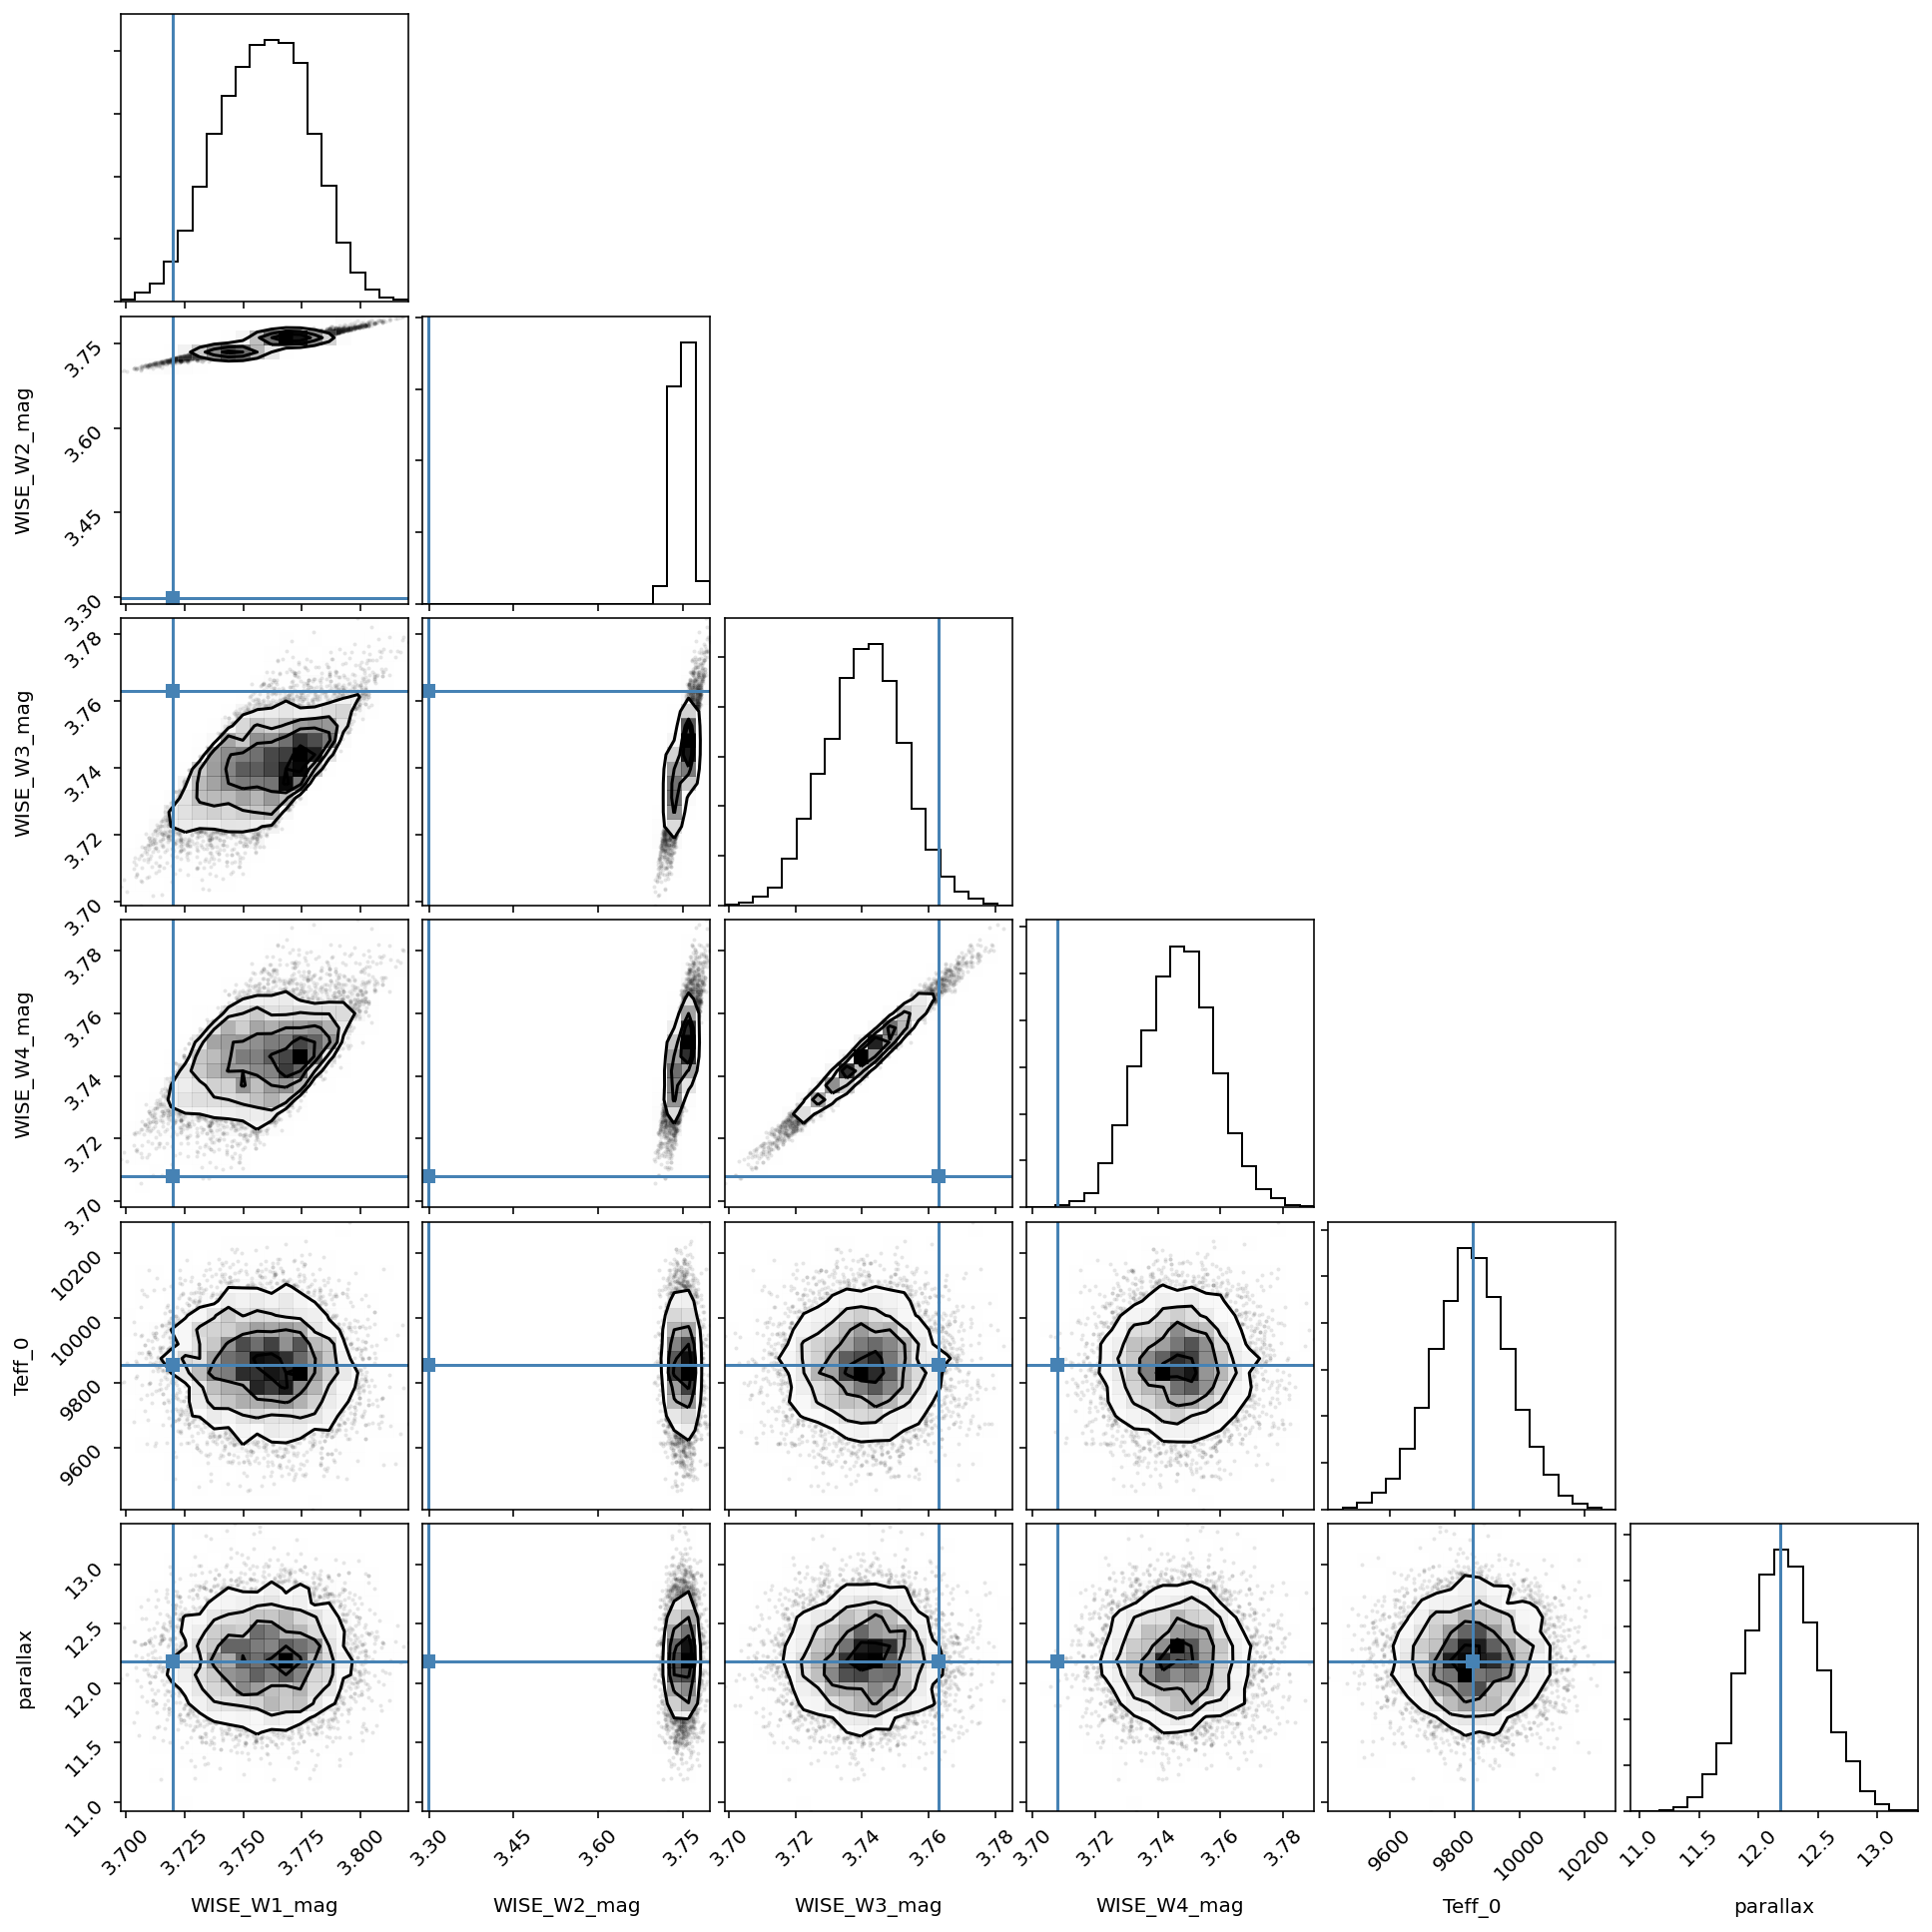

In [46]:
mod_binary.corner_observed();

In [47]:
from isochrones.mist import MISTEvolutionTrackGrid, MISTIsochroneGrid

track_grid = MISTEvolutionTrackGrid()
track_grid.df.head()  # just show first few rows

interpolating missing values in evolution tracks (feh=-4.0)': 100%|██████████| 196/196 [00:00<00:00, 466.56it/s]
interpolating missing values in evolution tracks (feh=-3.5)': 100%|██████████| 196/196 [00:01<00:00, 98.24it/s]
interpolating missing values in evolution tracks (feh=-3.0)': 100%|██████████| 196/196 [00:03<00:00, 58.02it/s]
interpolating missing values in evolution tracks (feh=-2.5)': 100%|██████████| 196/196 [00:03<00:00, 52.95it/s]
interpolating missing values in evolution tracks (feh=-2.0)': 100%|██████████| 196/196 [00:03<00:00, 53.60it/s]
interpolating missing values in evolution tracks (feh=-1.75)': 100%|██████████| 196/196 [00:01<00:00, 128.97it/s]
interpolating missing values in evolution tracks (feh=-1.5)': 100%|██████████| 196/196 [00:01<00:00, 149.14it/s]
interpolating missing values in evolution tracks (feh=-1.25)': 100%|██████████| 196/196 [00:01<00:00, 166.37it/s]
interpolating missing values in evolution tracks (feh=-1.0)': 100%|██████████| 196/196 [00:01<00:0

KeyboardInterrupt: 